<a href="https://colab.research.google.com/github/JinghengYu21/Cookie-Cat-A-B-Testing/blob/main/A_B_Test_Mobile_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loading and Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
df.info()
#No misssing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Check number of users in each group

In [ ]:
df[['userid','version']].groupby('version').count()

,userid
version,
gate_30,44700
gate_40,45489


Players were assigned randomly to either gate_30 or gate_40.
The two groups have roughly the same number of users, which is good

### Visualization

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Correlation Matrix & Heatmap

In [ ]:
df['retention_1']=df['retention_1'].astype(int)
df['retention_7']=df['retention_7'].astype(int)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [ ]:
corr_matrix = df.corr()
corr_matrix

<ipython-input-7-208d05607fc1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,userid,sum_gamerounds,retention_1,retention_7
userid,1.000000,0.001847,-0.002596,-0.002636
sum_gamerounds,0.001847,1.000000,0.197603,0.279288
retention_1,-0.002596,0.197603,1.000000,0.327401
retention_7,-0.002636,0.279288,0.327401,1.000000


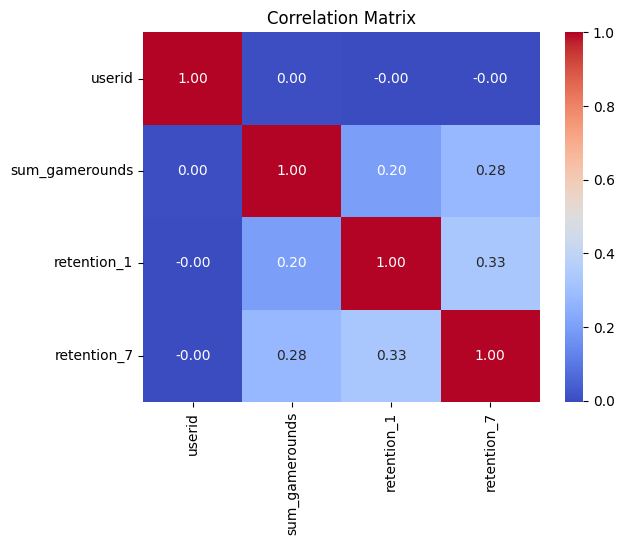

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The heatmap reveals that the correlation coefficient between
"retention_7" and the sum of game rounds (0.28) is stronger than the correlation between "retention_7" and the first-day value (0.2)\
This indicates that the retention rate on the 7-th day is more positively influenced by the cumulative game rounds than by the initial day's value.

Box Plot

<Axes: >

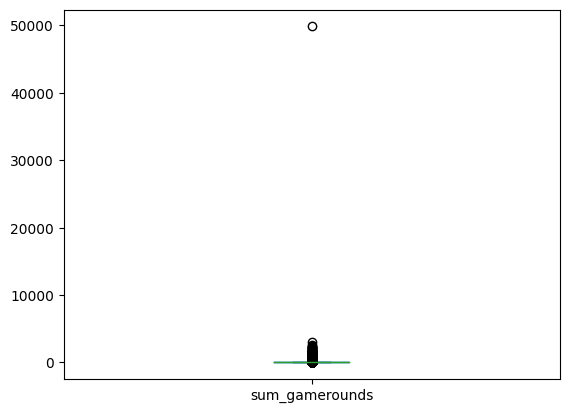

In [ ]:
df['sum_gamerounds'].plot.box()

The user played 50000 game rounds during the first week is clearly an outlier. The box plot is skewed and not very informative


In [ ]:
#Check percentile
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [ ]:
# number of users in each game round
df_sub1=df.groupby('sum_gamerounds')[['userid']].count()
df_sub1

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629
...,...
2294,1
2438,1
2640,1


<p>As we can see, 50% of players played fewer than 16 game rounds during the first week after installation, and 75% of players played fewer than 51 rounds.
<p>Nearly 4000 players did not even play a single round after installation.

Line Plot

Text(0, 0.5, 'Number of Players')

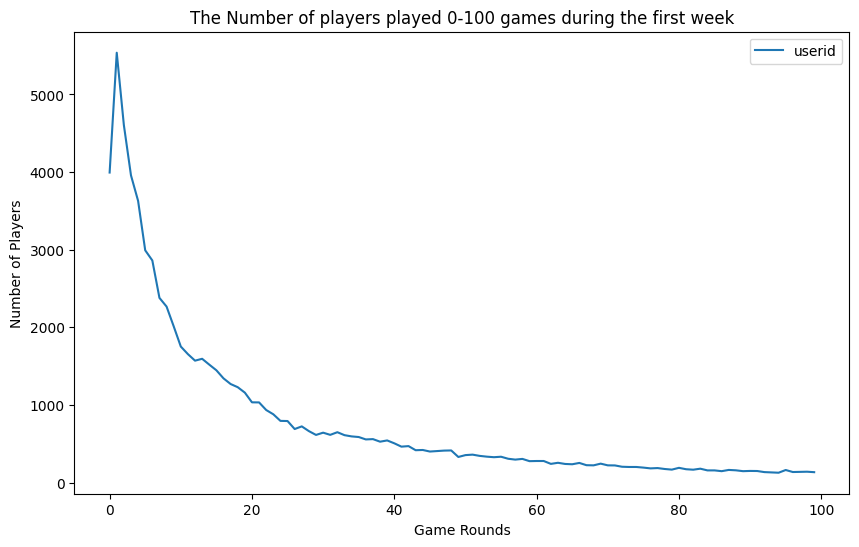

In [ ]:
#distribution of players that played 0 to 100 game rounds during their first week playing the game.
ax = df_sub1[:100].plot(figsize=(10,6))
ax.set_title('The Number of players played 0-100 games during the first week')
ax.set_xlabel('Game Rounds')
ax.set_ylabel('Number of Players')

A large number of players played less than 20 rounds.The distribution is strongly skewed, with a long right tail. For rounds greater than 60, the player counts remianed steady around 300.

### 1-day Retention

In [ ]:
df['retention_1'].sum()/df['retention_1'].count()

0.4452095044850259

In [ ]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

### 7-day Retention

In [ ]:
df['retention_7'].sum()/df['retention_7'].count()

0.1860648194347426

In [ ]:
df['retention_7'].mean() #mean=(x1+x2+x3)/3, n=3

0.1860648194347426

In [ ]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

### Z-Test

1-day rentetion

Assume gate_40 doesn't have a higher retention rate than gate_30 in the first day at the 5% Type I error, the hypothesis is: \
Null: **$p_{40}$**-**$p_{30}$** <= 0 \
Alternative: **$p_{40}$** - **$p_{30}$** > 0


In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [ ]:
old_gate = df[df['version']=='gate_30'].retention_1.sum()
new_gate = df[df['version']=='gate_40'].retention_1.sum()
num_old = len(df[df['version']=='gate_30'].retention_1)
num_new = len(df[df['version']=='gate_40'].retention_1)

In [ ]:
def z_test(p1,p0,n1,n0):
    # diff between 2 proportion
    delta = p1-p0
    #weighted average of the two proportions based on their respective sample sizes
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0)) #standard error of the difference between the proportions.

In [ ]:
#the proportion of successes in the new group
# the number of successes (convert_new) is divided by the total number of observations (n_new)
p1 = new_gate / num_new
#the proportion of successes in the old group
p0 = old_gate / num_old
n1 = num_new
n0 = num_old

In [ ]:
z_value = z_test(p1,p0,n1,n0)
z_value

-1.7840862247974725

In [ ]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)
p_value

0.9627951723515404

Since P-value > 0.05, we cannot reject the null hypothesis. The gate_30 has a higher retention rate than the gate_40 in the first day

7-day rentetion\
Assume gate_40 doesn't have a higher retention rate than gate_30 in the 7-th day at the 5% Type I error, the hypothesis is: \
Null: **$p_{40}$**-**$p_{30}$** <= 0 \
Alternative: **$p_{40}$** - **$p_{30}$** > 0

In [ ]:
old_gate7 = df[df['version']=='gate_30'].retention_7.sum()
new_gate7 = df[df['version']=='gate_40'].retention_7.sum()
num_old7 = len(df[df['version']=='gate_30'].retention_7)
num_new7 = len(df[df['version']=='gate_40'].retention_7)

In [ ]:
#the proportion of successes in the new group
# the number of successes (convert_new) is divided by the total number of observations (n_new)
p1 = new_gate7 / num_new7
#the proportion of successes in the old group
p0 = old_gate7 / num_old7
n1 = num_new7
n0 = num_old7

In [ ]:
z_value = z_test(p1,p0,n1,n0)
z_value

-3.164358912748191

In [ ]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)
p_value

0.9992228750121929

Since P-value > 0.05, we cannot reject the null hypothesis. The gate_30 has a higher retention rate than the gate_40 in the 7-th day

### Bootstrapping Method

We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

1-day Retention

In [ ]:
df.sample(frac=1,replace=True)

,userid,version,sum_gamerounds,retention_1,retention_7
7999,882283,gate_30,4,0,0
81980,9084093,gate_30,72,1,0
6984,774291,gate_30,25,1,0
21096,2347891,gate_40,25,0,1
961,106600,gate_30,375,1,1
...,...,...,...,...,...
58666,6496152,gate_30,81,1,0
58665,6496069,gate_40,216,1,1
63503,7033263,gate_40,12,0,0
74600,8266812,gate_30,25,0,0


In [ ]:
df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()

version
gate_30    0.453137
gate_40    0.440307
Name: retention_1, dtype: float64

In [ ]:
df.groupby('version')['retention_1'].mean()
#Because of sampling with replacement. some rows may be selected multiple times

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Perform bootstarpping to estimate the distribution of mean retention rate for different versions of a product

In [ ]:
# Creating an list with bootstrapped means for each AB-group,store the bootstrapped mean retention rates for each iteration.
boot_1d = []
#This loop iterates 1000 times
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

<Axes: ylabel='Density'>

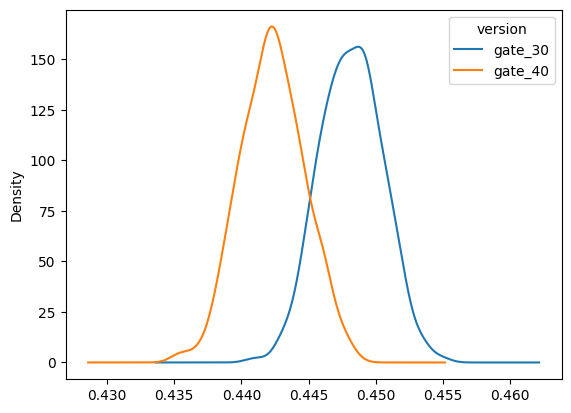

In [ ]:
boot_value=[]
for i in range(500):
  boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
  boot_value.append(boot_mean)

boot_value = pd.DataFrame(boot_value)
boot_value.plot(kind='density')

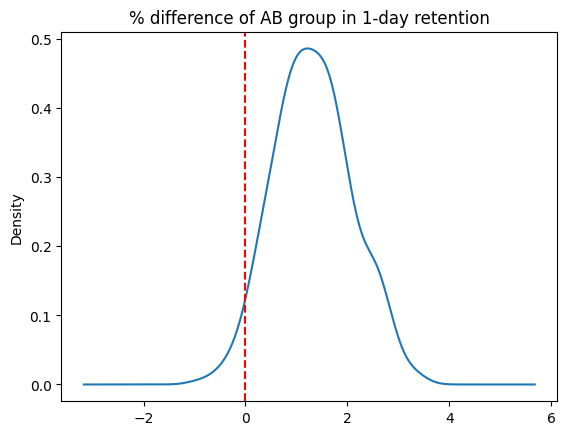

Probability that 1-day retention rate of gate gate_30 is greater than gate_40: 0.968


In [ ]:
# Adding a column with the % difference between the two AB-groups
boot_value['diff'] = (boot_value.gate_30-boot_value.gate_40)/boot_value.gate_40*100
boot_value['diff']
#plot the difference of bootstrap
ax = boot_value['diff'].plot(kind='density')
ax.set_title('% difference of AB group in 1-day retention')
ax.axvline(x=0, color='red', linestyle='--')
plt.show()
print('Probability that 1-day retention rate of gate gate_30 is greater than gate_40:',(boot_value['diff'] > 0).mean())

7-th day retention

In [ ]:
df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()

version
gate_30    0.192139
gate_40    0.184982
Name: retention_7, dtype: float64

In [ ]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

<Axes: ylabel='Density'>

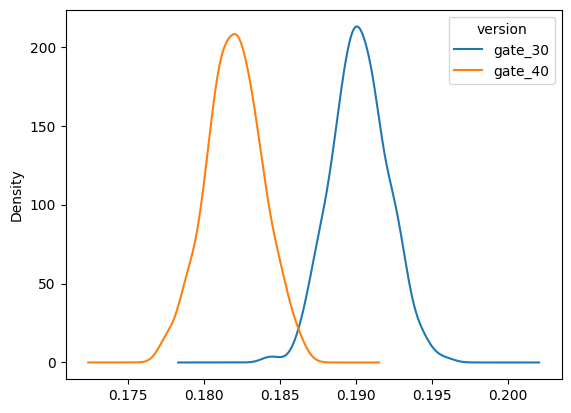

In [ ]:
boot_value=[]
for i in range(500):
  boot_mean=df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
  boot_value.append(boot_mean)

boot_value=pd.DataFrame(boot_value)
boot_value.plot(kind='density')

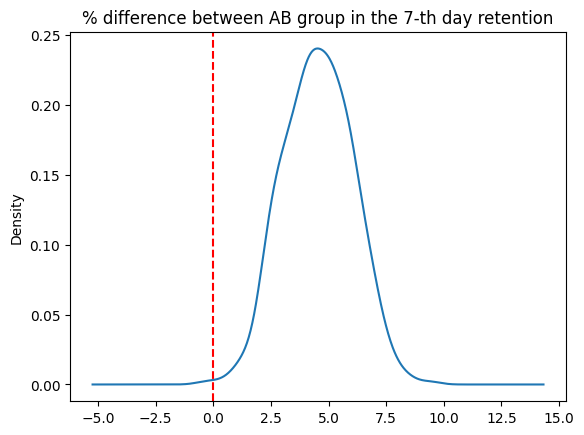

Probability that the 7-th day retention rate is greater when the gate level is at 40: 0.998


In [ ]:
#% difference between AB group in the 7-th day retention
boot_value['diff'] = (boot_value.gate_30- boot_value.gate_40)/boot_value.gate_40*100
ax = boot_value['diff'].plot(kind='density')
ax.set_title('% difference between AB group in the 7-th day retention')
ax.axvline(x=0,color='red',linestyle = '--')
plt.show()
print('Probability that the 7-th day retention rate is greater when the gate level is at 40:',(boot_value['diff']>0).mean())

conclusion

### statsmodel method

In [ ]:
import statsmodels.api as sm

In [ ]:
z_score, p_value = sm.stats.proportions_ztest([new_gate, old_gate], [num_new, num_old], alternative='larger')
z_score, p_value

(-1.7840862247974725, 0.9627951723515404)

In [ ]:
z_score, p_value = sm.stats.proportions_ztest([new_gate7, old_gate7], [num_new7, num_old7], alternative='larger')
z_score, p_value

(-3.164358912748191, 0.9992228750121929)

### Conclusion